# **Experiment Notebook**



## Context


### 0. Import Packages

In [1]:
! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.1.1 which is incompatible.


In [111]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### 1.   Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the folder containing the CSV files
files = glob.glob("/content/drive/MyDrive/final/*.csv")

# Initialize an empty list to hold all DataFrames
dfs = []

# Iterate through each file path
for file_path in files:
    # Read the file into a DataFrame, without a header, using a pipe as a separator
    df = pd.read_csv(file_path, header=None, sep="|")
    # Add a new column containing the file name only (excluding the directory path)
    df['source_file'] = file_path.split('/')[-1]
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into one DataFrame
salesdata = pd.concat(dfs, ignore_index=True)

In [ ]:
salesdata.columns = salesdata.iloc[0]

In [ ]:
salesdata = salesdata[1:]

In [ ]:
salesdata = salesdata.rename(columns={'transactions_12.csv': 'source files'})

In [ ]:
salesdata['source files'].nunique()

In [ ]:
salesdata.to_csv('/content/drive/MyDrive/merged_transactions.csv', index=False)

In [4]:
transaction_file_path = '/content/drive/MyDrive/merged_transactions.csv'
customers_file_path = '/content/drive/MyDrive/customers.csv'

In [74]:
# Read transaction file with low_memory=False
transactions_df = pd.read_csv(transaction_file_path, low_memory=False)

# Read customers file with error handling
customers_df = pd.read_csv(customers_file_path, sep='|', quoting=csv.QUOTE_NONE, on_bad_lines='skip')

### 2. Explore Dataset

In [75]:
# Display the first few rows to understand the structure
print("Transactions DataFrame:")
print(transactions_df.head())

Transactions DataFrame:
                cc_num      acct_num                         trans_num  \
0  4896331812335761701  149852234418  f3ec0819590302134f03ffdc2f44697f   
1  4896331812335761701  149852234418  c1607c993e41f2c3b42d72d1506bef7b   
2  4896331812335761701  149852234418  6f530db25d20fe351249a54491fd3fde   
3  4896331812335761701  149852234418  6d11805f2acd938fec99376001afafe8   
4  4896331812335761701  149852234418  605342f297c575cb1ccf2c08cad082ee   

    unix_time       category    amt is_fraud                     merchant  \
0  1646060228  gas_transport  65.17        0       Larson, Ryan and Huang   
1  1644848624  gas_transport  47.58        0                   Myers-Reed   
2  1645632153  gas_transport  64.43        0                Baker-Bullock   
3  1645311286  gas_transport  82.47        0                 Spencer-Hall   
4  1641571926  gas_transport  50.28        0  King, Rodriguez and Hancock   

   merch_lat  merch_long         source files  
0   38.14343  -90.32

In [76]:
print("\nCustomers DataFrame:")
print(customers_df.head())


Customers DataFrame:
           ssn               cc_num     first       last gender  \
0  115-04-4507        4218196001337  Jonathan    Johnson      M   
1  715-55-5575  4351161559407816183    Elaine     Fuller      F   
2  167-48-5821        4192832764832   Michael    Cameron      M   
3  406-83-7518     4238849696532874   Brandon   Williams      M   
4  697-93-1877     4514627048281480      Lisa  Hernandez      F   

                       street        city state    zip      lat     long  \
0        863 Lawrence Valleys      Ambler    PA  19002  40.1809 -75.2156   
1  310 Kendra Common Apt. 164      Leland    NC  28451  34.2680 -78.0578   
2            05641 Robin Port     Cordova    SC  29039  33.4275 -80.8857   
3      26916 Carlson Mountain  Birmingham    AL  35242  33.3813 -86.7046   
4             809 Burns Creek       Fargo    GA  31631  30.7166 -82.5801   

   city_pop                                    job         dob      acct_num  
0     32412                  Accounting

In [77]:
# Get a concise summary of the transactions DataFrame
print("Transactions DataFrame Info:")
print(transactions_df.info())

Transactions DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4261035 entries, 0 to 4261034
Data columns (total 11 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   cc_num        object
 1   acct_num      object
 2   trans_num     object
 3   unix_time     object
 4   category      object
 5   amt           object
 6   is_fraud      object
 7   merchant      object
 8   merch_lat     object
 9   merch_long    object
 10  source files  object
dtypes: object(11)
memory usage: 357.6+ MB
None


In [78]:
# Get a concise summary of the customers DataFrame
print("Customers DataFrame Info:")
print(customers_df.info())

Customers DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ssn       1000 non-null   object 
 1   cc_num    1000 non-null   int64  
 2   first     1000 non-null   object 
 3   last      1000 non-null   object 
 4   gender    1000 non-null   object 
 5   street    1000 non-null   object 
 6   city      1000 non-null   object 
 7   state     1000 non-null   object 
 8   zip       1000 non-null   int64  
 9   lat       1000 non-null   float64
 10  long      1000 non-null   float64
 11  city_pop  1000 non-null   int64  
 12  job       1000 non-null   object 
 13  dob       1000 non-null   object 
 14  acct_num  1000 non-null   int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 117.3+ KB
None


In [79]:
# Display descriptive statistics for numerical features in transactions data
print("Transactions DataFrame Description:")
print(transactions_df.describe())

Transactions DataFrame Description:
                 cc_num     acct_num  trans_num  unix_time      category  \
count           4261035      4261035    4261035    4261035       4261035   
unique              984          984    4260905    4114753            15   
top     347208496498560  11546128003  trans_num  unix_time  shopping_pos   
freq              10912        10912        131        131        420268   

            amt is_fraud   merchant  merch_lat  merch_long  \
count   4261035  4261035    4261035    4261035     4261035   
unique    81219        3      21978    3767590     4031686   
top        1.02        0  Smith PLC  merch_lat  merch_long   
freq       1879  4255870       5737        131         131   

               source files  
count               4261035  
unique                  132  
top     transactions_40.csv  
freq                 224902  


In [80]:
# Display descriptive statistics for categorical features in transactions data
print("Transactions DataFrame Categorical Description:")
print(transactions_df.describe(include=['object', 'category']))

Transactions DataFrame Categorical Description:
                 cc_num     acct_num  trans_num  unix_time      category  \
count           4261035      4261035    4261035    4261035       4261035   
unique              984          984    4260905    4114753            15   
top     347208496498560  11546128003  trans_num  unix_time  shopping_pos   
freq              10912        10912        131        131        420268   

            amt is_fraud   merchant  merch_lat  merch_long  \
count   4261035  4261035    4261035    4261035     4261035   
unique    81219        3      21978    3767590     4031686   
top        1.02        0  Smith PLC  merch_lat  merch_long   
freq       1879  4255870       5737        131         131   

               source files  
count               4261035  
unique                  132  
top     transactions_40.csv  
freq                 224902  


In [81]:
# Display descriptive statistics for numerical features in customers data
print("Customers DataFrame Description:")
print(customers_df.describe())

Customers DataFrame Description:
             cc_num          zip          lat         long      city_pop  \
count  1.000000e+03   1000.00000  1000.000000  1000.000000  1.000000e+03   
mean   3.656964e+17  51786.20900    37.422795   -92.505277  2.867058e+05   
std    1.227337e+18  29933.13195     5.574397    17.510134  5.329632e+05   
min    6.040027e+10   1571.00000    19.589300  -159.368300  1.050000e+02   
25%    1.800353e+14  27528.25000    33.712500   -99.159475  2.022950e+04   
50%    3.517359e+15  49016.00000    38.431750   -87.156600  6.728250e+04   
75%    4.538733e+15  78599.00000    41.220300   -80.018850  2.499788e+05   
max    4.986227e+18  99705.00000    64.780500   -68.244800  2.906700e+06   

           acct_num  
count  1.000000e+03  
mean   4.995849e+11  
std    2.894933e+11  
min    2.348758e+09  
25%    2.620636e+11  
50%    4.915295e+11  
75%    7.571575e+11  
max    9.993899e+11  


In [82]:
# Display descriptive statistics for categorical features in customers data
print("Customers DataFrame Categorical Description:")
print(customers_df.describe(include=['object', 'category']))

Customers DataFrame Categorical Description:
                ssn    first      last gender                street      city  \
count          1000     1000      1000   1000                  1000      1000   
unique         1000      367       487      2                  1000       736   
top     115-04-4507  Michael  Williams      F  863 Lawrence Valleys  Brooklyn   
freq              1       25        24    512                     1        13   

       state                       job         dob  
count   1000                      1000        1000  
unique    51                       507         978  
top       CA  Computer games developer  1962-11-16  
freq     107                         7           2  


### 3. Convert Data Types and Handle Missing Values

In [83]:
# Convert relevant columns to appropriate types in transactions data
transactions_df['cc_num'] = pd.to_numeric(transactions_df['cc_num'], errors='coerce')
transactions_df['acct_num'] = pd.to_numeric(transactions_df['acct_num'], errors='coerce')
transactions_df['amt'] = pd.to_numeric(transactions_df['amt'], errors='coerce')
transactions_df['is_fraud'] = pd.to_numeric(transactions_df['is_fraud'], errors='coerce')
transactions_df['merch_lat'] = pd.to_numeric(transactions_df['merch_lat'], errors='coerce')
transactions_df['merch_long'] = pd.to_numeric(transactions_df['merch_long'], errors='coerce')

# Convert unix_time to datetime
transactions_df['unix_time'] = pd.to_datetime(transactions_df['unix_time'], unit='s', errors='coerce')

# Check for missing values after conversion
print("\nMissing Values in Transactions Data after type conversion:")
print(transactions_df.isnull().sum())

# Handle missing values (example: drop rows with missing values)
transactions_df = transactions_df.dropna(subset=['cc_num', 'acct_num', 'unix_time', 'amt', 'is_fraud', 'merch_lat', 'merch_long'])

# Confirm that the data types have been changed and there are no more missing values
print("\nTransactions DataFrame Info after type conversion and handling missing values:")
print(transactions_df.info())

<ipython-input-83-081cfcf80618>:10: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  transactions_df['unix_time'] = pd.to_datetime(transactions_df['unix_time'], unit='s', errors='coerce')



Missing Values in Transactions Data after type conversion:
cc_num          131
acct_num        131
trans_num         0
unix_time       131
category          0
amt             131
is_fraud        131
merchant          0
merch_lat       131
merch_long      131
source files      0
dtype: int64

Transactions DataFrame Info after type conversion and handling missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 4260904 entries, 0 to 4261034
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   cc_num        float64       
 1   acct_num      float64       
 2   trans_num     object        
 3   unix_time     datetime64[ns]
 4   category      object        
 5   amt           float64       
 6   is_fraud      float64       
 7   merchant      object        
 8   merch_lat     float64       
 9   merch_long    float64       
 10  source files  object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 390.1+ MB
None

In [84]:
# Merge transactions_df with customers_df on 'cc_num'
merged_df = pd.merge(transactions_df, customers_df, on=['cc_num', 'acct_num'], how='inner')

# Display the first few rows of the merged DataFrame
print("Merged DataFrame:")
print(merged_df.head())

# Check for missing values in the merged DataFrame
print("\nMissing Values in Merged DataFrame:")
print(merged_df.isnull().sum())

# Confirm that the merge was successful and the DataFrame contains the expected number of rows and columns
print("\nMerged DataFrame Info:")
print(merged_df.info())

Merged DataFrame:
         cc_num      acct_num                         trans_num  \
0  4.896332e+18  1.498522e+11  f3ec0819590302134f03ffdc2f44697f   
1  4.896332e+18  1.498522e+11  c1607c993e41f2c3b42d72d1506bef7b   
2  4.896332e+18  1.498522e+11  6f530db25d20fe351249a54491fd3fde   
3  4.896332e+18  1.498522e+11  6d11805f2acd938fec99376001afafe8   
4  4.896332e+18  1.498522e+11  605342f297c575cb1ccf2c08cad082ee   

            unix_time       category    amt  is_fraud  \
0 2022-02-28 14:58:08  gas_transport  65.17       0.0   
1 2022-02-14 14:24:00  gas_transport  47.58       0.0   
2 2022-02-23 16:02:08  gas_transport  64.43       0.0   
3 2022-02-19 22:53:52  gas_transport  82.47       0.0   
4 2022-01-07 16:12:48  gas_transport  50.28       0.0   

                      merchant  merch_lat  merch_long  ... gender  \
0       Larson, Ryan and Huang  38.143430  -90.327335  ...      M   
1                   Myers-Reed  39.119498  -90.760379  ...      M   
2                Baker-Bulloc

### 4. Perform EDA

In [85]:
# Display basic statistics for numeric columns
print("Basic Statistics for Numeric Columns:")
print(merged_df.describe())

Basic Statistics for Numeric Columns:
             cc_num      acct_num                      unix_time  \
count  4.108383e+06  4.108383e+06                        4108383   
mean   2.429927e+17  4.948025e+11  2021-05-06 04:40:27.965743616   
min    6.040027e+10  2.348758e+09            2018-12-31 13:00:48   
25%    1.800322e+14  2.581163e+11            2020-04-22 12:30:56   
50%    3.516698e+15  4.734608e+11            2021-07-17 07:21:36   
75%    4.491342e+15  7.601677e+11            2022-06-11 07:19:28   
max    4.983666e+18  9.993899e+11            2022-12-31 12:58:40   
std    1.022969e+18  2.898354e+11                            NaN   

                amt      is_fraud     merch_lat    merch_long           zip  \
count  4.108383e+06  4.108383e+06  4.108383e+06  4.108383e+06  4.108383e+06   
mean   6.911735e+01  1.178809e-03  3.734163e+01 -9.243195e+01  5.190168e+04   
min    1.000000e+00  0.000000e+00  1.859001e+01 -1.603677e+02  1.571000e+03   
25%    9.130000e+00  0.000000e+00

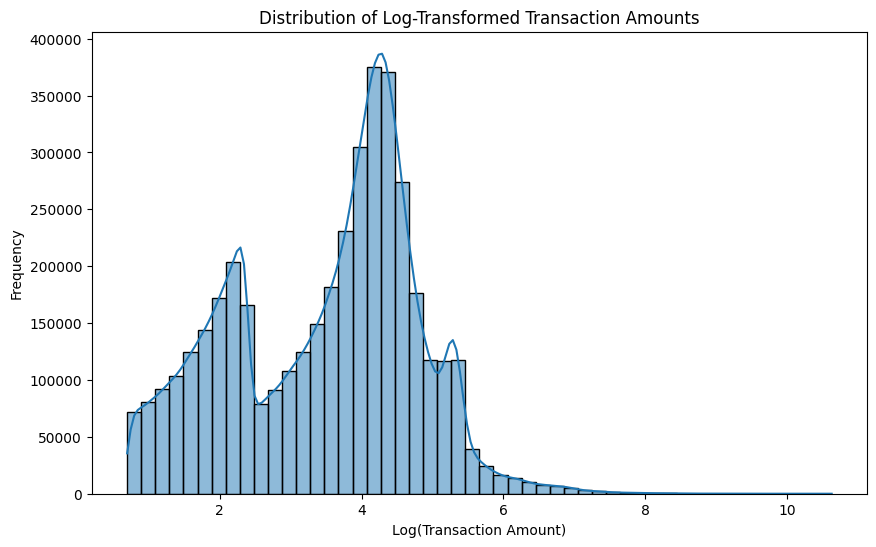

In [87]:
# Apply log transformation to the transaction amounts
merged_df['log_amt'] = np.log1p(merged_df['amt'])

# Plot the distribution of log-transformed transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['log_amt'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Transaction Amounts')
plt.xlabel('Log(Transaction Amount)')
plt.ylabel('Frequency')
plt.show()

year_month     object
amt           float64
dtype: object


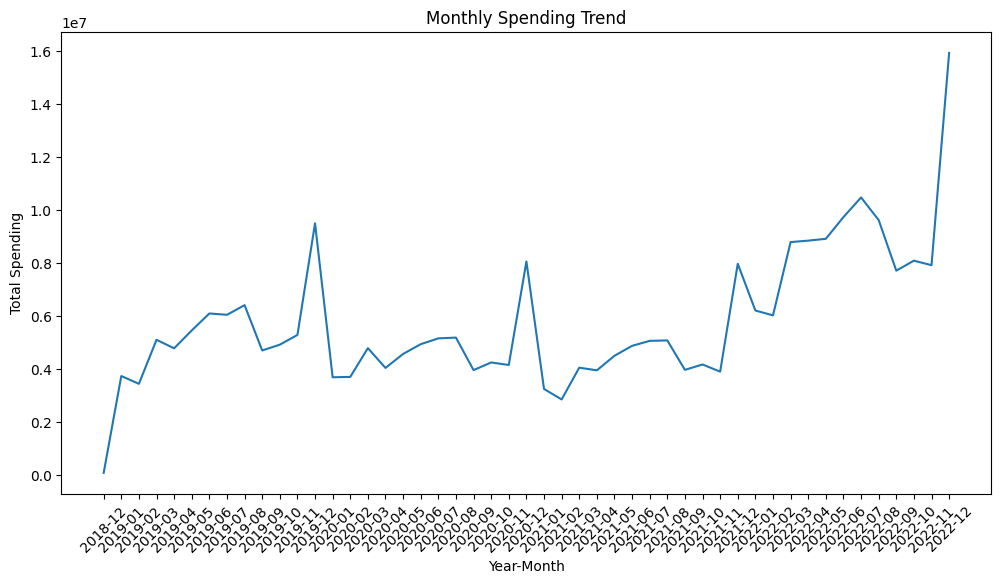

In [88]:
# Extract year and month from unix_time
merged_df['year_month'] = merged_df['unix_time'].dt.to_period('M')

# Group by year_month to get the total spending per month
monthly_spending = merged_df.groupby('year_month')['amt'].sum().reset_index()

# Ensure correct data types for plotting
monthly_spending['year_month'] = monthly_spending['year_month'].astype(str)
monthly_spending['amt'] = pd.to_numeric(monthly_spending['amt'], errors='coerce')

# Confirm the changes in data types
print(monthly_spending.dtypes)

# Plot the monthly spending trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_spending, x='year_month', y='amt')
plt.title('Monthly Spending Trend')
plt.xlabel('Year-Month')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.show()

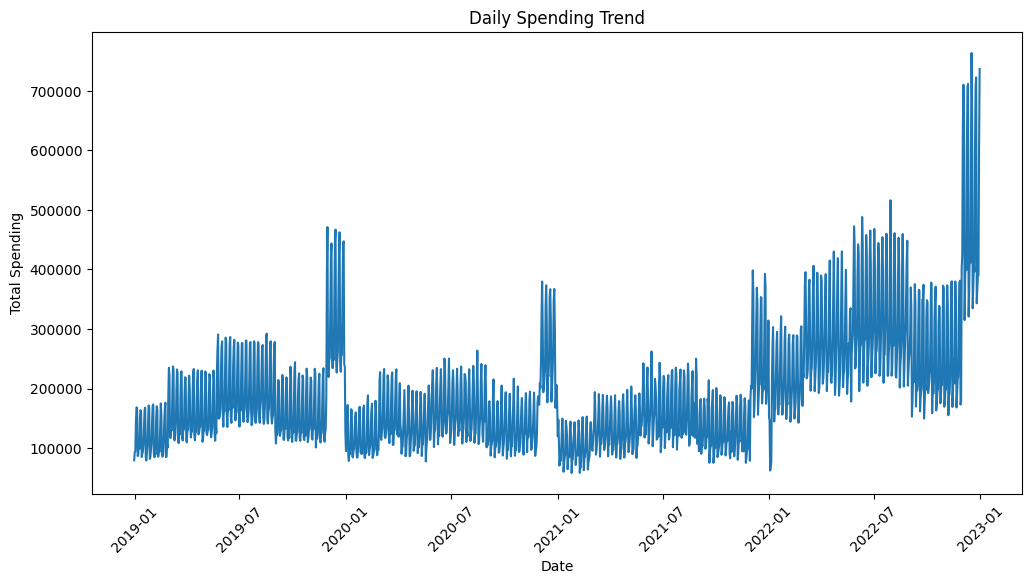

In [89]:
# Time series analysis of transaction amounts
merged_df['transaction_date'] = merged_df['unix_time'].dt.date

# Group by transaction date to get the total spending per day
daily_spending = merged_df.groupby('transaction_date')['amt'].sum().reset_index()

# Plot the daily spending trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_spending, x='transaction_date', y='amt')
plt.title('Daily Spending Trend')
plt.xlabel('Date')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.show()

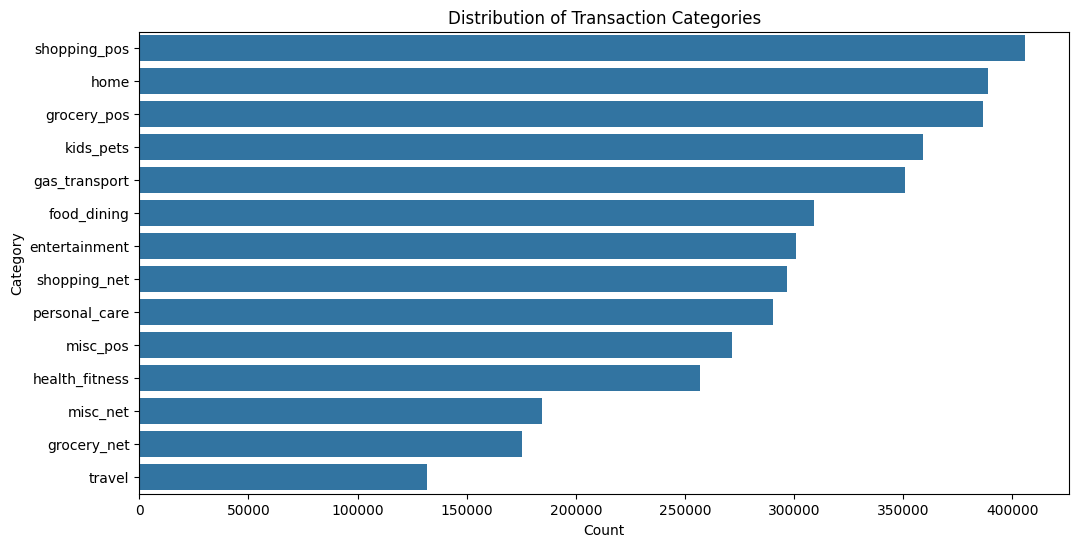

In [90]:
# Plot the distribution of categories
plt.figure(figsize=(12, 6))
sns.countplot(y=merged_df['category'], order=merged_df['category'].value_counts().index)
plt.title('Distribution of Transaction Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

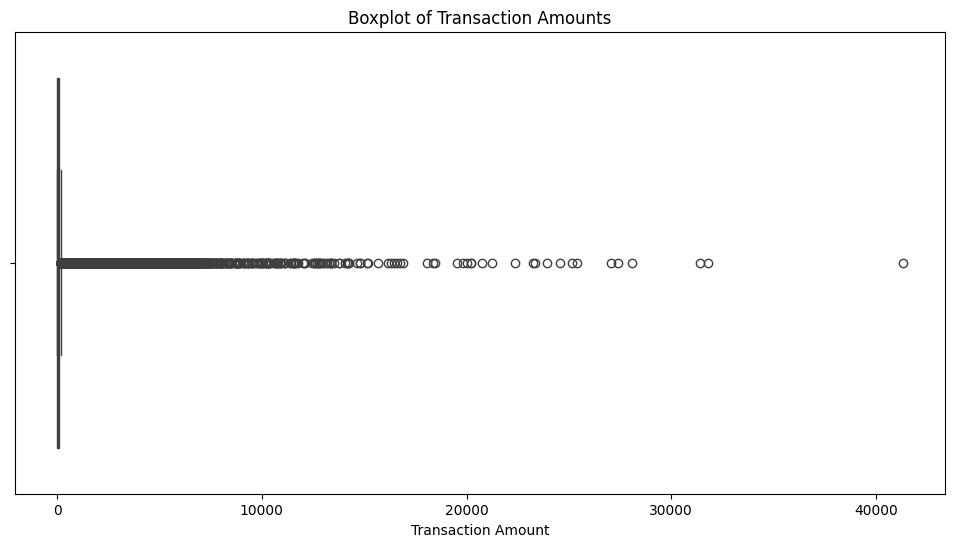

In [91]:
# Detect outliers in the 'amt' column
plt.figure(figsize=(12, 6))
sns.boxplot(x=merged_df['amt'])
plt.title('Boxplot of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.show()

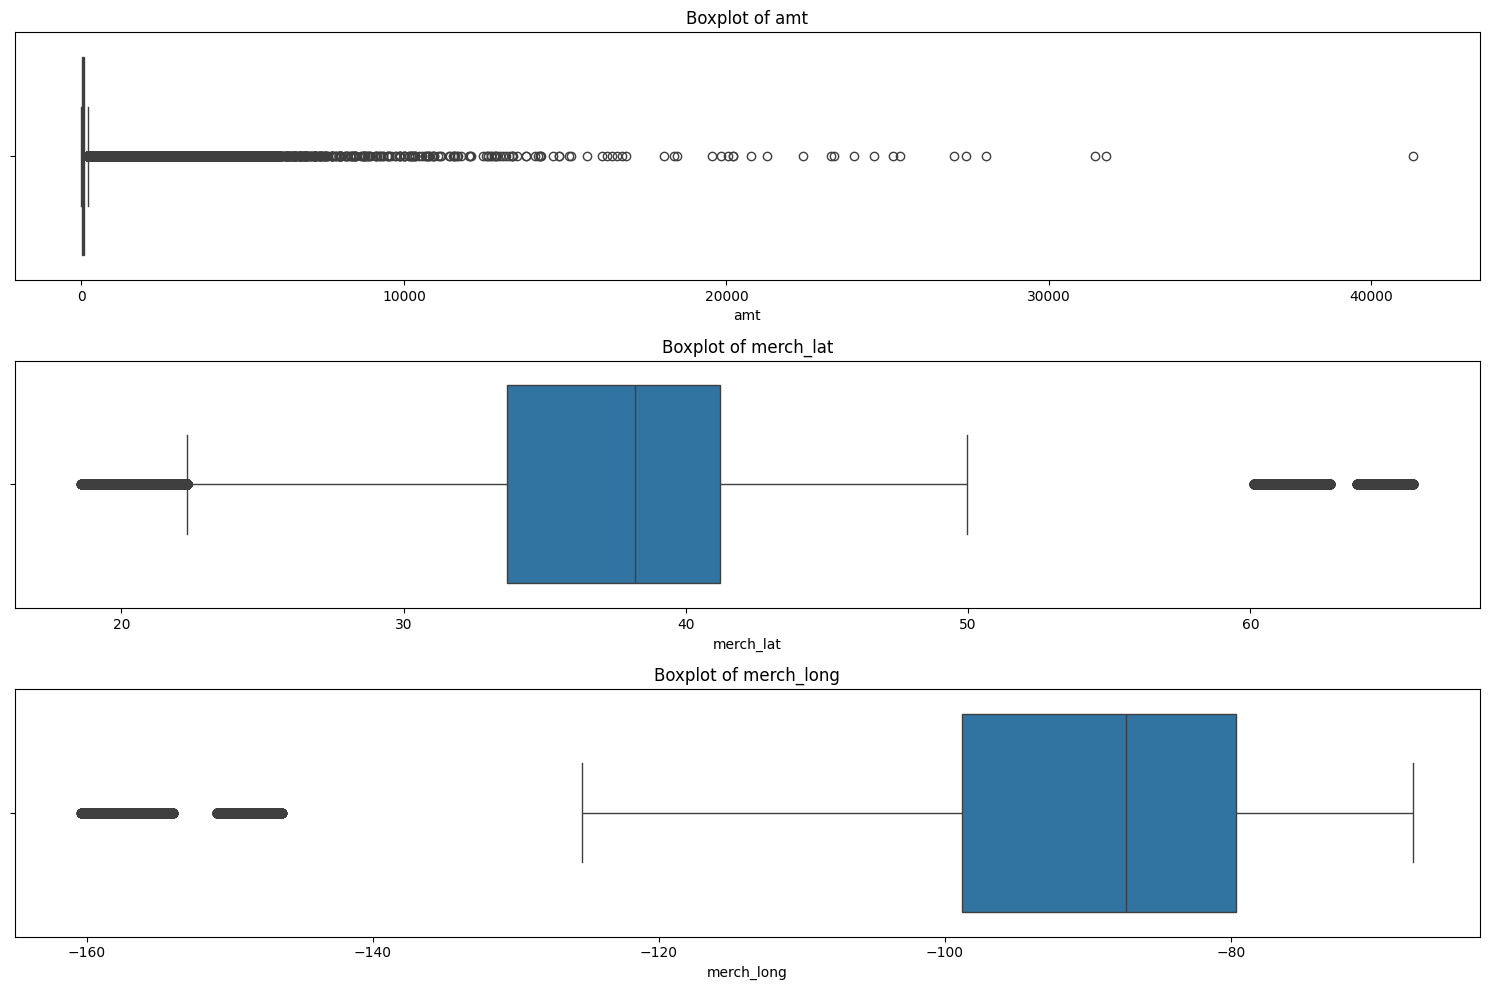

In [92]:
# Boxplots for numerical features
numerical_features = ['amt', 'merch_lat', 'merch_long']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=merged_df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

Numeric columns: ['cc_num', 'acct_num', 'amt', 'is_fraud', 'merch_lat', 'merch_long', 'zip', 'lat', 'long', 'city_pop', 'log_amt']


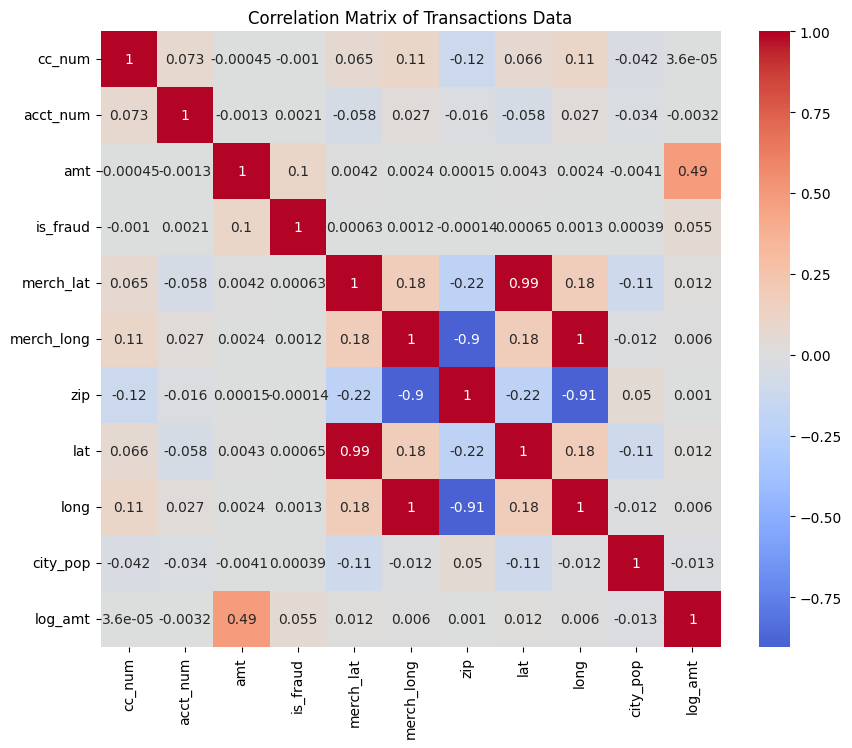

In [93]:
# Select only the numeric columns
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

# Compute correlations between numerical features in the transactions data
correlation_matrix = merged_df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Transactions Data')
plt.show()

### 5. Prepare Data

In [94]:
# Feature Engineering: Create lag features for the spending amount of previous months
transactions_df = transactions_df.sort_values(by=['cc_num', 'unix_time'])
transactions_df['prev_amt'] = transactions_df.groupby('cc_num')['amt'].shift(1)

# Drop rows with missing values created by the shift operation
transactions_df = transactions_df.dropna()

# Ensure the transactions_df DataFrame is clean
df_cleaned = transactions_df.copy()

# Define features and target variable
X = df_cleaned[['prev_amt']]
y = df_cleaned['amt']

### 6. Split Dataset

In [95]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3407936, 1)
y_train shape: (3407936,)
X_test shape: (851985, 1)
y_test shape: (851985,)


### 7. Baseline Model

### 8. Train Machine Learning Model

#### Experiment 1: Linear Regression

In [104]:
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("Linear Regression - Test Set Performance:")
print("RMSE:", rmse)
print("R2-score:", r2)

Linear Regression - Test Set Performance:
RMSE: 164.38523570385019
R2-score: 0.0003032861635111628


#### Experiment 2: Ridge Regression

In [105]:
# Train a Ridge regression model
model = Ridge(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("Ridge Regression - Test Set Performance:")
print("RMSE:", rmse)
print("R2-score:", r2)

Ridge Regression - Test Set Performance:
RMSE: 164.38523570385004
R2-score: 0.0003032861635127171


#### Experiment 3: Lasso Regression

In [106]:
# Train a Lasso regression model
model = Lasso(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("Lasso Regression - Test Set Performance:")
print("RMSE:", rmse)
print("R2-score:", r2)

Lasso Regression - Test Set Performance:
RMSE: 164.3852174956188
R2-score: 0.0003035076275373916


#### Experiment 4: ElasticNet Regression

In [107]:
# Train an ElasticNet regression model
model = ElasticNet(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("ElasticNet Regression - Test Set Performance:")
print("RMSE:", rmse)
print("R2-score:", r2)

ElasticNet Regression - Test Set Performance:
RMSE: 164.38522637879564
R2-score: 0.0003033995827738112


#### Experiment 5: Polynomial Regression

In [112]:
# Generate polynomial features
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Train a linear regression model on polynomial features
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_poly_test)

# Calculate evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("Polynomial Regression - Test Set Performance:")
print("RMSE:", rmse)
print("R2-score:", r2)

Polynomial Regression - Test Set Performance:
RMSE: 164.36846272486815
R2-score: 0.0005072830303264331


### 9. Assess Model Performance